In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
from text_classification.models import TextClassificationLSTM
from text_classification.datasets import AllScamSpamDataset, SpamDetectionDataset

import pandas as pd
import seaborn as sns
from tokenizers import Tokenizer
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report

In [3]:
sns.set_theme()

In [4]:
# Tokenizer settings
MAX_SEQ_LEN = 200

# Model settings
NUM_CLASSES = 2
EMBEDDING_DIM = 100
HIDDEN_SIZE = 100
NUM_LAYERS = 1
DROPOUT = 0.1

# Train settings
NUM_EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 256
LEARNING_RATE = 3e-4

# Tokenizer

In [5]:
tokenizer = Tokenizer.from_file("../models/lstm_tokenizer.json")
tokenizer.enable_padding(pad_id=1, pad_token="[PAD]", length=MAX_SEQ_LEN)
tokenizer.enable_truncation(max_length=MAX_SEQ_LEN)

# Dataset

In [6]:
dataset = AllScamSpamDataset(tokenizer)
train_data, val_data, test_data = random_split(dataset, [0.7, 0.15, 0.15])

# Training

In [ ]:
model = TextClassificationLSTM(
    num_classes=NUM_CLASSES,
    vocab_size=tokenizer.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)

In [8]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

In [9]:
history = model.fit(train_loader, val_loader, LEARNING_RATE, NUM_EPOCHS, PATIENCE)

Epoch  1/50: loss=0.5231, accuracy=0.7511, precision=0.7450, recall=0.7319, f1_score=0.7351
Epoch  2/50: loss=0.3771, accuracy=0.8458, precision=0.8402, recall=0.8510, f1_score=0.8424
Epoch  3/50: loss=0.2715, accuracy=0.8938, precision=0.8879, recall=0.8973, f1_score=0.8909
Epoch  4/50: loss=0.2476, accuracy=0.9054, precision=0.8999, recall=0.9113, f1_score=0.9030
Epoch  5/50: loss=0.1970, accuracy=0.9243, precision=0.9209, recall=0.9226, f1_score=0.9214
Epoch  6/50: loss=0.1786, accuracy=0.9345, precision=0.9307, recall=0.9342, f1_score=0.9320
Epoch  7/50: loss=0.1794, accuracy=0.9303, precision=0.9268, recall=0.9286, f1_score=0.9275
Epoch  8/50: loss=0.1558, accuracy=0.9423, precision=0.9398, recall=0.9405, f1_score=0.9399
Epoch  9/50: loss=0.1493, accuracy=0.9467, precision=0.9439, recall=0.9457, f1_score=0.9446
Epoch 10/50: loss=0.1472, accuracy=0.9464, precision=0.9441, recall=0.9446, f1_score=0.9442
Epoch 11/50: loss=0.1481, accuracy=0.9485, precision=0.9473, recall=0.9459, f1_s

In [10]:
model.save("../models/spam_lstm.pt")

# Performance

In [11]:
history = pd.DataFrame(history)

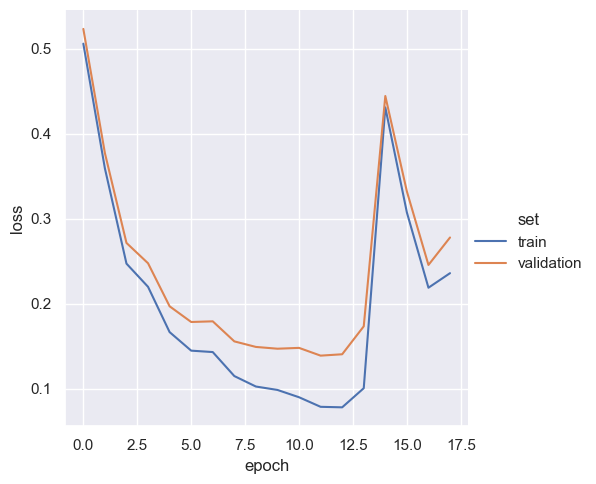

In [12]:
g = sns.relplot(history, x="epoch", y="loss", hue="set", kind="line")

In [13]:
test_loader = DataLoader(test_data, batch_size=len(test_data))
inputs, targets = next(iter(test_loader))
targets = targets.argmax(dim=1).numpy()
preds = model.predict(inputs).numpy()

print("Classification report on test set")
print(classification_report(targets, preds))

Classification report on test set
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3758
           1       0.94      0.95      0.94      2634

    accuracy                           0.95      6392
   macro avg       0.95      0.95      0.95      6392
weighted avg       0.95      0.95      0.95      6392



In [14]:
dataset = SpamDetectionDataset(tokenizer)
test_loader = DataLoader(dataset, batch_size=len(dataset))
inputs, targets = next(iter(test_loader))
targets = targets.argmax(dim=1).numpy()
preds = model.predict(inputs).numpy()

print("Classification report on another data set")
print(classification_report(targets, preds))